# HW 6 Contrastive learning

This assignment aims to have you learn how to modify loss functions and simultaneously process multiple feature vectors in both face verification and face recognition tasks by using the CelebA dataset as an example.

CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations, covering a wide range of pose variations and background clutter. The dataset is pruned so that the training time is appropriate for the assignment.

This homework is divided into three parts:

1. Face verification with contrastive loss
2. Face verification with triplet loss
3. Face verification with InfoNCE loss
4. Face verification evaluation


# Import main libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
from collections import defaultdict
from PIL import Image
import math
from tqdm.notebook import tqdm
import random

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Download data

In [3]:
# # uncomment the following lines to download the data
# !pip install gdown
# !gdown 1_2oATmA0Jw61qs7I7kAG9Q2LHNZSQX7A
# !unzip large_prepared_data.zip

# Common dataset

In [4]:
class FaceDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.label_df = pd.read_csv(f'{self.root_dir}/label_df.csv')

  def __len__(self):
    return len(self.label_df)

  def __getitem__(self, idx):
    data = self.label_df.iloc[idx]
    img = Image.open(f"{self.root_dir}/{data['filename']}").convert('RGB')
    if self.transform is not None:
        transformed_img = self.transform(img)
    else:
        transformed_img = None
    identity = data['identity']
    return transformed_img, identity, np.array(img)

This is an example to display a face image with its identity

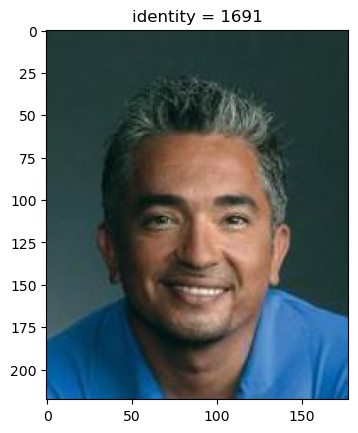

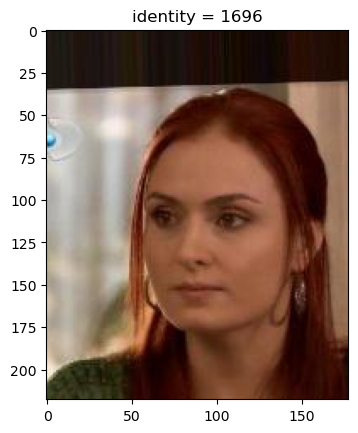

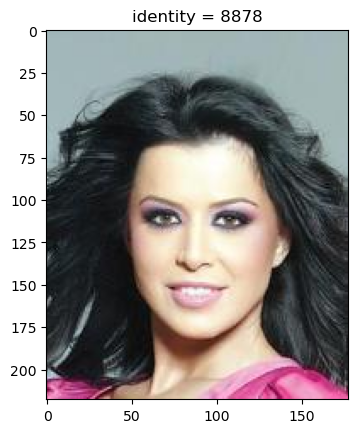

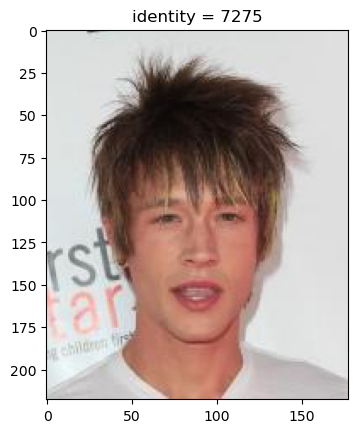

In [5]:
import matplotlib.pyplot as plt
face_dataset = FaceDataset(root_dir='large_prepared_data/test')

for idx in range(4):
  _, identity, img = face_dataset[idx]
  plt.title(f'identity = {identity}')
  plt.imshow(img)
  plt.show()

# Part 1: Face verification with contrastive loss

The objective of the face verification task is to validate whether the face image $x$ has the identity $y$ by comparing it to the face database of the claimed identity. If the face similarity score between $x$ and the face in the database of $y$ is above a certain threshold, the image is then verified; otherwise, the identity is rejected.

In HW3, you have learned to calculate a similarity score based on compact image representation using a PCA / Fisher projection. Therefore, in this part, you will instead implement a more contemporary method by training the NN to propose a compact representation (feature vector) by using a Siamese network and contrastive loss (Chopra et al., 2005, https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1467314).

In contrast to the classification task that forces the model to learn all possible classes of objects, the general idea of object verification is based on contrastive learning, a framework that teaches the model to distinguish the two objects from each other. For a contrastive loss, the model will receive a pair of image and then learn to recognize whether both of them has the same identity by encouraging the feature vector of the same identity to come closer and different one to move away from each other.

## 1.1 (TODO) Dataset and DataLoader

First, we will start by writing a dataloader. The contrastive loss learns whether a pair of images have the same identity. Therefore, in this subsection, you have to write a dataloader that returns the tuple `(img1, img2, is_same_identity (bool))`.

**File structure of this dataset**
```
- large_prepared_data/
└───train/
|    - {img1}.jpg
|    - {img2}.jpg
|    - label_df.csv
└───val/
|    - {img3}.jpg
|    - {img4}.jpg
|    - label_df.csv
└───test/
    - {img5}.jpg
    - {img6}.jpg
    - label_df.csv
```
**Note**

label_df.csv has 2 columns that are the filename such as 001257.jpg and the identity such as 1691


**Instructions**

TODO 1-4: Fill in the missing code in the cells below. \
TODO 1-2: Organize the dataset for simple data access. \
TODO 3: Randomly select the datapoint from the dataset and format it to be ready for training. \
TODO 4: Initialize the dataloader.

In [6]:
class SiameseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        '''
        The dataset of siamese network
        [Args]
        - root_dir = root directory of the dataset
        - transform = transformations for images
      '''
        np.random.seed(123)
        random.seed(123)
        self.root_dir = root_dir
        self.transform = transform
        label_df = pd.read_csv(f'{root_dir}/label_df.csv')
        self.num_images = len(label_df)
        label_df = label_df.groupby('identity')['filename'].apply(list).reset_index().rename({'filename': 'filenames'}, axis=1)
        self.load_images_to_memory_(label_df)

    def load_images_to_memory_(self, label_df):
        '''
        Load all images into memory
        [Args]
        - label_df = The dataframe containing the identities and the filenames of images
      '''
        # TODO 1: load images to `self.data` according to the below structure
        # and `self.images`, `self.identities` following by idx
        # Note: identity{i}: str, image{i}: PIL.Image (convert them to RGB as well)
        # e.g. self.data = {
        #   'identity1': [image1, image2],
        #   'identity2': [image3, image4, image5],
        # }
        #
        # identity{i}: str, image{i}: PIL.Image
        self.data = {identity: [Image.open(f"{self.root_dir}/{filename}").convert('RGB') for filename in filenames] for identity, filenames in zip(label_df['identity'], label_df['filenames'])}
        self.images = [img for identity in self.data.values() for img in identity]
        self.identities = [identity for identity in self.data.keys() for _ in range(len(self.data[identity]))]

        # print(self.data)

        # TODO 2: keep all unique identities as list with `self.unique_identities`
        # in `self.unique_identities` as a numpy array.
        self.unique_identities = np.array(list(self.data.keys()))

    # def get_identity_from_image_index(self, idx):
    #     return [
    #         identity
    #         for identity in self.unique_identities
    #         if self.images[idx] in self.data[identity]
    #     ][0]

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        '''
      Return a pair of image together with its label
      [Args]
      - idx: int
      [Return]
      - img1: torch.FloatTensor
      - img2: torch.FloatTensor
      - label: totch.FloatTensor = 1 (same class), 0 (different class)
      '''
        # TODO 3: randomly sample a pair of images
        # Note: idx is even, it should return the same class pair and otherwise
        # Please use label = 1 for the same class pair
        # and label = 0 for the different class pair
        img1 = self.images[idx]

        identity = [
            identity
            for identity in self.unique_identities
            if img1 in self.data[identity]
        ][0]
        # print(identity)

        img2 = (
            random.choice(self.data[identity])
            if idx % 2 == 0
            else random.choice(self.data[random.choice(np.delete(self.unique_identities, np.where(self.unique_identities == identity)))])
        )

        # identity = [
        #     identity
        #     for identity in self.unique_identities
        #     if img2 in self.data[identity]
        # ][0]
        # print(identity)

        img1 = self.transform(img1)
        img2 = self.transform(img2)

        label = 1 - idx % 2 
        # print(idx, label)

        return img1, img2, torch.from_numpy(np.array([label], dtype=np.float32))

In [7]:
img_size = 224
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5319, 0.4399, 0.3929],
                          std=[0.3076, 0.2898, 0.2907])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5319, 0.4399, 0.3929],
                          std=[0.3076, 0.2898, 0.2907])
])

train_batch_size = 16
val_batch_size = 16
test_batch_size = 16


# TODO 4: declare the datasets and the dataloaders
train_siamese_dataset = SiameseDataset(root_dir='large_prepared_data/train', transform=train_transform)
train_siamese_dataloader = DataLoader(train_siamese_dataset, batch_size=train_batch_size, shuffle=True)

val_siamese_dataset = SiameseDataset(root_dir='large_prepared_data/val', transform=val_transform)
val_siamese_dataloader = DataLoader(val_siamese_dataset, batch_size=val_batch_size, shuffle=False)

test_siamese_dataset = SiameseDataset(root_dir='large_prepared_data/test', transform=val_transform)
test_siamese_dataloader = DataLoader(test_siamese_dataset, batch_size=test_batch_size, shuffle=False)

In [8]:
# Let's check the shape of the data
img1, img2, label = next(iter(train_siamese_dataloader))
print(img1.shape, img2.shape, label.shape)

torch.Size([16, 3, 224, 224]) torch.Size([16, 3, 224, 224]) torch.Size([16, 1])


## 1.2 (TODO) Siamese network

After the dataloader is initialized, we then build a siamese network. Section 1.5 will explain how a siamese network works in full detail.

Siamese network is a typical CNN that consists of three modules:

1. A feature extractor (ResNet18) for extracting the feature map from an image.
2. A global pooling for reducing the image dimension.
3. A fully connected layer for compressing the feature vector

Every fully connected layer is followed by ReLU activations.


TODO 5: Implement a siamese network based on the description.

**Note**
1. You can use the ResNet18 from the `torchvision` library (How to use torchvision: https://pytorch.org/vision/stable/models.html)
2. We will not use pretrained weights.



Figure 1 Siamese network

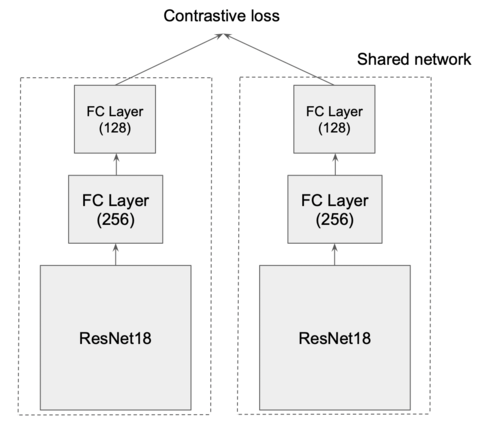

In [9]:
from torchvision.models import resnet18

class SiameseNetwork(nn.Module):
  # TODO 5: implement the siamese network
  def __init__(self):
      super().__init__()
      self.resnet = resnet18(weights=None)
      self.ff1 = nn.Linear(1000, 256)
      self.ff2 = nn.Linear(256, 128)

  def extract_feature(self, x):
      output_resnet = F.relu(self.resnet(x))
      output_ff1 = F.relu(self.ff1(output_resnet))
      output = F.relu(self.ff2(output_ff1))  
      return output

  def forward(self, input1, input2):
      output1 = self.extract_feature(input1)
      output2 = self.extract_feature(input2)
      return output1, output2

In [10]:
SiameseNetwork();

In [11]:
out1, out2 = SiameseNetwork()(img1, img2)

In [12]:
out1, out1.shape, out2.shape

(tensor([[0.0000, 0.0000, 0.1167,  ..., 0.1257, 0.0182, 0.0000],
         [0.0000, 0.0000, 0.1276,  ..., 0.1464, 0.0149, 0.0088],
         [0.0000, 0.0000, 0.1315,  ..., 0.1176, 0.0176, 0.0000],
         ...,
         [0.0000, 0.0000, 0.1322,  ..., 0.1317, 0.0390, 0.0000],
         [0.0000, 0.0027, 0.1229,  ..., 0.1669, 0.0268, 0.0000],
         [0.0000, 0.0000, 0.1388,  ..., 0.1280, 0.0165, 0.0000]],
        grad_fn=<ReluBackward0>),
 torch.Size([16, 128]),
 torch.Size([16, 128]))

## 1.3 (TODO) Constrastive loss
A contrastive loss is a loss used to minimize the dissimilarity between two images by encouraging the feature vector of the same identity to come closer and different one further than a constant margin $m$ to move away from each other.


The contrastive loss is mathematically defined as:


$
L\ (contrastive\ loss ) = \begin{cases}
                        d(r_1, r_2) & if\ identity(r1) = identity(r2) \\
                        max(0, m - d(r_1, r_2)) & if\ identity(r1) \neq identity(r2) \\
                    \end{cases}
\
$

where

- $d(r_1, r_2)$ = euclidean distance between $r_1$ and $r_2$  
- $m$ = margin
- $identity(x)$ = the identity of x
- $r_1$ = the feature vector of the first image
- $r_2$ = the feature vector of the second image


The term $d(r_1, r_2)$ is the distance between the two feature vectors. The contrastive loss minimizes the distance between the feature vectors of the same identity (positive pair) but maximizes the distance of the different identities (negative pair).

The margin $m$ is used to prevent the loss from collapsing to a trivial solution. For instance, when $m = 0$, the model could achieve $L = 0$ just by exploiting the objective by setting $r_1 = r_2$, and the model, as a result, would learn nothing useful.

**HINT**

Many torch functions often have the same functionality as NumPy functions, even sharing the same function name. Therefore, if you are struggling with this part, you might write the loss using NumPy first and then convert it to the torch function (https://pytorch.org/docs/stable/torch.html) later.
**Avoid using "if statements" to make the training faster. You have already learned many tricks that convert if statements into a single equation.**

TODO 6: Implement a contrastive loss based on the description above.

In [56]:
import torch
from torch import nn
import torch.nn.functional as F

class ContrastiveLoss(torch.nn.Module):
  # TODO 6: implement the contrastive loss
  def __init__(self, margin):
    super().__init__()
    self.margin = margin

  def forward(self, output1, output2, label):
    dist = torch.sqrt(torch.sum((output1 - output2) ** 2, dim=1))
    loss_contrastive = torch.mean((label) * dist + 
                                  (1-label) * torch.clamp(self.margin - dist, min=0.0))
    return loss_contrastive

In [57]:
t1 = torch.Tensor([[10, 1], [0, 10]])
t2 = torch.Tensor([[10, 10], [0, 0]])
t_label = torch.Tensor([1, 0])

ContrastiveLoss(1)(t1, t2, t_label)

tensor(4.5000)

In [58]:
ContrastiveLoss(1)(out1, out2, label)

tensor(0.5606, grad_fn=<MeanBackward0>)

## 1.4 Initiazing the model, criterion, optimizer and scheduler

In [59]:
siamese_margin = 2
learning_rate = 1e-4

siamese_model = SiameseNetwork()
siamese_criterion = ContrastiveLoss(margin=siamese_margin)
siamese_optimizer = optim.Adam(siamese_model.parameters(), lr=learning_rate)
siamese_scheduler = optim.lr_scheduler.ReduceLROnPlateau(siamese_optimizer, 'min', patience=5, factor=0.1, min_lr=1e-8)

## 1.5 (TODO) Training loop

The training procedure of a siamese network consists of the following steps:

1. Forward pass the `img1`.
2. Forward pass the `img2`.
3. Calculate the distance between the feature vector of `img1` and `img2` $(d(r_1, r_2))$.
4. Use the distance in step 3 as a loss and update the model.
5. Repeat step 1-4 until satisfied.

As you would notice, both first and second step shares the same network weights. Therefore, the word "Siamese" in the siamese network originates from the "Siamese twins" since the network performs two forward passes to compare whether the feature vectors have the same identity by using the same set of network parameters (shared parameters).

TODO 7-8: Feed pairs of images to the network, compute contrastive loss to measure the dissimilarity of pairs of face images and update the network.

TODO 9: Feed a pair of images from validation set to the network and compute the validation loss.

**Trivia**

The Siamese twin is a conjoined twin brother born in Siam who later move to the US (https://th.wikipedia.org/wiki/%E0%B8%AD%E0%B8%B4%E0%B8%99-%E0%B8%88%E0%B8%B1%E0%B8%99).

In [ ]:
num_epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"
siamese_model.to(device)

os.makedirs("weights", exist_ok=True)
best_weights_path = "weights/best_siamese_weights.pth"

train_losses = []
val_losses = []
min_val_loss = float("inf")

for epoch in tqdm(range(num_epochs)):
    siamese_model.train()
    total_train_loss = 0

    for img1, img2, label in tqdm(train_siamese_dataloader):

        # TODO 7: feed data to model and compute loss
        output1, output2 = siamese_model(img1.to(device), img2.to(device))
        train_loss = siamese_criterion(output1, output2, label.to(device))

        # TODO 8: back propagate
        siamese_optimizer.zero_grad()
        train_loss.backward()
        siamese_optimizer.step()

        total_train_loss += train_loss.item()

    current_train_loss = total_train_loss / len(train_siamese_dataloader)
    train_losses.append(current_train_loss)

    total_val_loss = 0
    siamese_model.eval()
    for val_img1, val_img2, val_label in val_siamese_dataloader:

        # TODO 9: feed data to model and compute loss
        output1, output2 = siamese_model(val_img1.to(device), val_img2.to(device))
        val_loss = siamese_criterion(output1, output2, val_label.to(device))

        total_val_loss += val_loss.item()
    current_val_loss = total_val_loss / len(val_siamese_dataloader)
    val_losses.append(current_val_loss)
    if current_val_loss < min_val_loss:
        min_val_loss = current_val_loss
        torch.save(siamese_model.state_dict(), best_weights_path)
    print(
        f'Epoch {epoch+1} - Train loss = {current_train_loss:.4f} - Val loss = {current_val_loss:.4f} - best min_val_loss = {min_val_loss:.4f} - lr = {siamese_optimizer.param_groups[0]["lr"]:.8f}'
    )
    siamese_scheduler.step(current_val_loss)

## 1.6 Visualization

This visualization displays pairs of images together with the distance between those pairs.

In [ ]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(120, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


siamese_model.load_state_dict(torch.load(best_weights_path))
siamese_model.eval()

test_img1s, test_img2s, test_labels = next(iter(test_siamese_dataloader))
test_img1s, test_img2s, test_labels = test_img1s.to(device), test_img2s.to(device), test_labels.to(device)
with torch.no_grad():
    test_out1s, test_out2s = siamese_model(test_img1s, test_img2s)

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnormalizer = UnNormalize(mean=[0.5319, 0.4399, 0.3929],
                          std=[0.3076, 0.2898, 0.2907])

for test_out1, test_out2, test_img1, test_img2, test_label in zip(test_out1s, test_out2s, test_img1s, test_img2s, test_labels):
    test_img1 = unnormalizer(test_img1.detach().cpu().unsqueeze(0))
    test_img2 = unnormalizer(test_img2.detach().cpu().unsqueeze(0))
    concatenated = torch.cat((test_img1, test_img2), 0)
    distance = F.pairwise_distance(test_out1.unsqueeze(0), test_out2.unsqueeze(0))
    imshow(torchvision.utils.make_grid(concatenated), f'Label = {int(test_label[0])}, Distance: {distance.item():.4f}')

## 1.7 Plot loss history

In [ ]:
plt.plot(np.arange(1, len(train_losses)+1), train_losses, label='train loss')
plt.plot(np.arange(1, len(val_losses)+1), val_losses, label='val loss')
plt.legend()
plt.show()

## 1.8 (TODO) Plot t-SNE  

After the training process is finished, we evaluate whether the learned representation is informative. In this task, embedding visualization is often performed to verify that the feature learned by the network is behaving as intended, i.e., feature vectors of the same identity should be close to each other and far away from other identities. Since the feature vector dimension is too high for a human to interpret, therefore, in this assignment, we use the t-SNE dimensionality reduction technique to compress the feature into a 2D space.


**Instructions**

TODO 10: Extract the feature vectors of the test set and store them as

`embeddings`: torch.FloatTensor = feature vectors of all images in the test set

`identities`: list or torch.Tensor or np.array = identities of all images in the test set

**Hint**      
Use `FaceDataset` that is imported at `Common Dataset` section

**WARNING!!**
Don't forget load its best weights and change to eval mode first

In [123]:
test_batch_size = 32

# TODO 10: Extract the feature vectors of the test set and store them as
# `embeddings`: torch.FloatTensor = feature vectors of all images in the test set
# `identities`: list or torch.Tensor or np.array = identities of all images in the test set
# Hint      => Use `FaceDataset` that is imported at `Common Dataset` section
# WARNING!! => Don't forget load its best weights and change to eval mode first

test_siamese_dataset = SiameseDataset(
    root_dir="large_prepared_data/test", transform=val_transform
)
test_siamese_dataloader = DataLoader(
    test_siamese_dataset, batch_size=test_batch_size, shuffle=False
)

embeddings = torch.FloatTensor()
identities = test_siamese_dataset.identities

siamese_model = SiameseNetwork()
siamese_model.load_state_dict(
    torch.load(best_weights_path, map_location=torch.device(device))
)
siamese_model.eval()

for i, (img1, _, _) in tqdm(enumerate(test_siamese_dataloader), total=len(test_siamese_dataloader)):
    with torch.no_grad():
        embeddings = torch.cat((embeddings, siamese_model.extract_feature(img1.to(device))), 0)

  0%|          | 0/10 [00:00<?, ?it/s]

In [125]:
embeddings.shape

torch.Size([301, 128])

In [17]:
import time
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=3000)
tsne_result = tsne.fit_transform(embeddings, identities)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 301 samples in 0.000s...
[t-SNE] Computed neighbors for 301 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 301 / 301
[t-SNE] Mean sigma: 0.061775
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.592178
[t-SNE] KL divergence after 1750 iterations: 0.194442
t-SNE done! Time elapsed: 2.1309101581573486 seconds


In [18]:
import plotly.express as px

# relabel to be easier to see in t-SNE visualization
label = []
idx = 0
id2label = dict()
for identity in identities:
  identity = int(identity)
  if identity not in id2label:
    id2label[identity] = idx
    idx += 1
  label.append(id2label[identity])

df_subset = pd.DataFrame({'label': label})

df_subset['tsne-2d-one'] = tsne_result[:,0]
df_subset['tsne-2d-two'] = tsne_result[:,1]

fig = px.scatter(df_subset, x="tsne-2d-one", y="tsne-2d-two", color="label", height=1000, width=1000)
fig.show()

## 1.9 (TODO) Analyzing feature vector visualization result

TODO 11: What could you say about the displayed visualization? Is the model working as expected?

Answer here: The embedding visualization shows that the feature vectors of the identity not so well cluster which could be due to the model collapse to a trivial solution. No, it is not working as expected.

## 2.1 Dataset and DataLoader

In this section, you are going to implement a dataloader for the combined loss.
The dataloader should return the tuple `(anchor_img, pos_img, neg_img, anchor_label, pos_label, neg_label)`.

- The positive image must have the same identity as the anchor image.
- The negative image must have a different identity from the anchor image.

# Part 2: Face verification with triplet loss + center loss


In contrast to contrastive loss which learns to distinguish whether the two images have the same identity, triplet loss is proposed as an alternative by introducing an anchor image as a third input. Triplet loss receives three inputs: anchor, positive pair, and negative pair. The positive pair is an image having the same identity as the anchor while the negative pair is the one with a different identity. The loss learns to minimize the distance between the anchor and positive pair, and maximize the distance between the anchor and the negative pair. Compared to contrastive loss, triplet loss offers more training stability and better model performance.

Nevertheless, both contrastive and triplet loss also has some shortcomings as these losses only optimize on a pairwise level. This might result in feature vectors of the same identity taking the form of multiple small clusters scattering across the feature space since there is no explicit loss to bind them into a single group. Therefore, a center loss is proposed to mitigate this problem by encouraging the intra-class (same identity) feature vectors to come closer to their intra-class centroids.

In this part, you are going to implement a face verification network by jointly training **three losses**: triplet, center, and cross-entropy loss.


In [18]:
class TripletDataset(Dataset):
    def __init__(self, root_dir, transform=None):
      np.random.seed(123)
      random.seed(123)
      self.root_dir = root_dir
      self.transform = transform

      label_df = pd.read_csv(f'{root_dir}/label_df.csv')
      label_df = label_df.groupby('identity')['filename'].apply(list).reset_index().rename({'filename': 'filenames'}, axis=1)
      self.images = []
      self.labels = []
      self.label2indices = dict()
      self.load_images_to_memory_(label_df)

    def load_images_to_memory_(self, label_df):
      # load images and labels into memory
      # We have to relabel from identities to 0,1,2,...,num_classes-1
      # Relevant variables
      # 1. `self.images` = PIL images  (Also convert it to RGB)
      # 2. `self.label2indices` = the dictionary storing a label as a key and the indices of images as value
      # 3. `self.labels` = labels of images (relabeled)
      # Note: the index of images is from iterating over label_df
      self.images = []
      self.label2indices = defaultdict(list)
      self.labels = []
      img_idx = 0
      label_idx = 0
      identity2label = dict()
      for idx in tqdm(range(len(label_df))):
          row = label_df.iloc[idx]
          identity, filenames = row['identity'], row['filenames']

          if identity not in identity2label:
            identity2label[identity] = label_idx
            label_idx += 1

          label = identity2label[identity]

          for filename in filenames:
              self.images.append(Image.open(f'{self.root_dir}/{filename}').convert('RGB'))
              self.labels.append(label)
              self.label2indices[label].append(img_idx)
              img_idx += 1


    def __len__(self):
      return len(self.images)

    def __getitem__(self, idx):
      # generate an anchor image, a positive image and a negative image together with anchor_label
      # anchor image is the image according to idx
      # positive image is the image that has the same identity with the anchor image
      # negative image is the image that has the different identity with the anchor image
      anchor_img = self.images[idx]
      anchor_label = self.labels[idx]

      pos_idx = random.choice(self.label2indices[anchor_label])
      while pos_idx == idx:
        pos_idx = random.choice(self.label2indices[anchor_label])
      pos_img = self.images[pos_idx]
      pos_label = anchor_label
      neg_label = random.choice(list(set(self.labels) - {anchor_label}))
      neg_img = self.images[random.choice(self.label2indices[neg_label])]


      # utilize `self.transform' to convert images to tensors
      if self.transform is not None:
          anchor_img = self.transform(anchor_img)
          pos_img = self.transform(pos_img)
          neg_img = self.transform(neg_img)


      return anchor_img, pos_img, neg_img, anchor_label, pos_label, neg_label


In [7]:
image_size = 224
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5319, 0.4399, 0.3929],
                          std=[0.3076, 0.2898, 0.2907])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5319, 0.4399, 0.3929],
                          std=[0.3076, 0.2898, 0.2907])
])

train_batch_size = 16
val_batch_size = 16
test_batch_size = 16

# declare the datasets and the dataloaders

train_triplet_dataset = TripletDataset(root_dir='large_prepared_data/train', transform=train_transform)
train_triplet_dataloader = DataLoader(train_triplet_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)

val_triplet_dataset = TripletDataset(root_dir='large_prepared_data/val', transform=val_transform)
val_triplet_dataloader = DataLoader(val_triplet_dataset, batch_size=val_batch_size, shuffle=False, num_workers=2)

test_triplet_dataset = TripletDataset(root_dir='large_prepared_data/test', transform=val_transform)
test_triplet_dataloader = DataLoader(test_triplet_dataset, batch_size=test_batch_size, shuffle=False, num_workers=2)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

## 2.2 Triplet Network

This network is a simpliflied version of strong baseline person re-identification task (ref: https://arxiv.org/abs/1903.07071)

Triplet network consists of 3 modules
1. Feature extractor (ResNet18) is for mapping an image to a feature map   
2. Global pooling (Global average pooling or use flatten instead) is for converting a feature map to a feature vector
3. Bottleneck (Batch normalization only scale not shift) is for the consistency of training between triplet loss and crossentropy because it is difficult to optimize those losses in embedding space at the same time
4. Linear classifier is to classify who this face is

**Note**
1. ResNet18 can call via `torchvision` library (How to use torchvision: https://pytorch.org/vision/stable/models.html)
2. ResNet18 we use will not load pretrained weights
3. We will use ResNet18 only extracting feature maps.

**Hint!**
1. For global average pooling, read the documentation of `nn.AdaptiveAvgPool2d`
2. For bottleneck, try `requires_grad_` method to stop calculating gradient at batch normalization


Figure 3 Triplet network

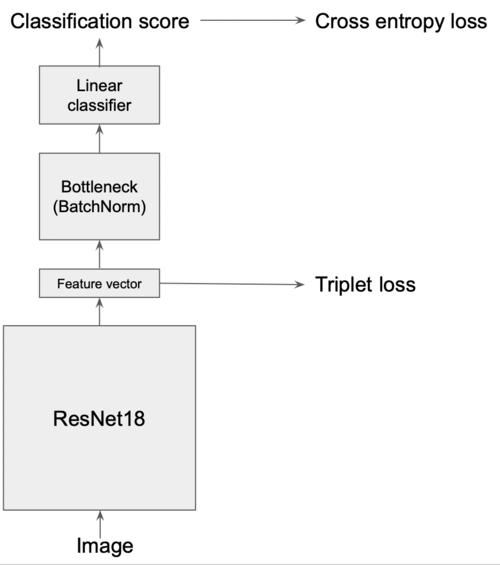


In [8]:
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if m.affine:
        nn.init.constant_(m.weight, 1.0)
        nn.init.constant_(m.bias, 0.0)

def weights_init_classifier(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, std=0.001)
        if m.bias:
            nn.init.constant_(m.bias, 0.0)

class TripletNetwork(nn.Module):
  # implement the triplet network
  def __init__(self, num_classes):
    super(TripletNetwork, self).__init__()
    resnet = torchvision.models.resnet18(pretrained=False)
    self.conv = torch.nn.Sequential(*(list(resnet.children())[:-1]))
    self.global_pool = nn.AdaptiveAvgPool2d(1)

    self.bottleneck = nn.BatchNorm1d(512)
    # no shift
    self.bottleneck.bias.requires_grad_(False)

    self.classifier = nn.Linear(512, num_classes, bias=False)

    self.bottleneck.apply(weights_init_kaiming)
    self.classifier.apply(weights_init_classifier)

  def extract_feature(self, x):
    x = self.conv(x)

    global_feat = self.global_pool(x)
    global_feat = global_feat.view(global_feat.size(0), -1)

    feat = self.bottleneck(global_feat)

    if not self.training:
      return feat

    cls_score = self.classifier(feat)

    return global_feat, cls_score

  def forward(self, anchor_img, pos_img, neg_img):
    anchor_feat, anchor_score = self.extract_feature(anchor_img)
    pos_feat, pos_score = self.extract_feature(pos_img)
    neg_feat, neg_score = self.extract_feature(neg_img)

    feats = torch.cat((anchor_feat, pos_feat, neg_feat))
    scores = torch.cat((anchor_score, pos_score, neg_score))
    return anchor_feat, pos_feat, neg_feat, feats, scores

## 2.3 Triplet loss

Triplet loss uses the same concept as contrastive loss that is the anchor image will pull the positive one closer and push the negative one further than the constant margin away. Hence, we have sampled three images to compute it.
The three images consist of:
1. an anchor image = an initial image
2. a positive image = the image having the same identity as the anchor image
3. a negative image = the image having a different identity from the anchor image

The triplet loss is mathematically defined as:

$L_{Triplet} = max(0, m + d(r_a, r_p) - d(r_a, r_n))$

where
- $d(r_1, r_2)$ = euclidean distance between $r_1$ and $r_2$
- $m$ = margin
- $r_a$ = the feature vector of the anchor image
- $r_p$ = the feature vector of the positive image
- $r_n$ = the feature vector of the negative image

The loss aims to minimize $d(r_a, r_p)$ while maximizing $d(r_a, r_n)$ at the same time.

The margin $m$ is used to prevent the loss from collapsing to a trivial solution. For instance, when $m = 0$, the model could achieve $L = 0$ just by exploiting the objective by setting $r_a = r_p = r_n$, and the model, as a result, would learn nothing useful.


In [9]:
class TripletLoss(nn.Module):
  # implement the triplet loss
  def __init__(self, margin=2.0):
    super(TripletLoss, self).__init__()
    self.margin = margin
    self.euclidean_dist_fn = nn.PairwiseDistance(p=2)

  def forward(self, anchor_img, pos_img, neg_img):
    pos_dist = self.euclidean_dist_fn(anchor_img, pos_img)
    neg_dist = self.euclidean_dist_fn(anchor_img, neg_img)
    return torch.mean(torch.relu(pos_dist - neg_dist + self.margin))

## 2.4 Center loss
Reference: https://ydwen.github.io/papers/WenECCV16.pdf

**Definition**

Centroid: a representative of each class. There are several ways to select a representative, one way to do this is to take an average on those embeddings.

**Concept**

Center loss enforces the intra-class feature vectors to come closer to the centroid of their class so that all feature vectors of the same identity are clustered around a single centroid. Since the model is updated after each iteration, the centroids should also be updated accordingly. However, re-calculating the centroids by averaging the feature vectors for each class every iteration is computational-extensive on a large scale. Therefore, the centroid is instead learned from the representative of each class from the sampled data.

**Implementation detail**

In `__init__` method
  1. For simplicity, we will store the centroids in the class `CenterLoss`. Therefore, you have to initialize the centroids as a random tensor with the size of `(num_classes, feature_dimension)`. The tensor has to be set with `nn.Paramater` so that the gradient could be calculated (ref: https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html).

In the `forward` method
  1. Calculate the distance between the feature vector and its center with a squared Euclidean distance
  2. Clip the value in each element to be not greater than 1e+12, not lower than 1e-12, and sum them  
  3. Normalize the loss with its batch size

**Center loss equation**

$L_{Center} = \frac{1}{B}\sum_{j=1}^{B}||f_{j} - c_{y_j}||_2^2$

where
- $f_{j}$ = a feature vector before fed into the bottleneck at index $j$
- $c_{y_j}$ = a center of the class corresponded to the index $j$
- B = batch size

The center loss minimized the distance between the feature vector and the centroid of the corresponded identity.

**Note**
1. At `__init__` method in step 1. Do not forget to transfer the parameters to GPU with `.cuda()` otherwise, it will not utilize GPU on this part.
2. Clip the magnitude of the loss at the final stage before updating both upper bound and lower bound to avoid vanishing / exploding gradients.

**Hint**
1. In step 2 of the `forward` method, you should use `torch.clamp` (ref: https://pytorch.org/docs/stable/generated/torch.clamp.html) to clip the lower bound and the upper bound as you want.

In [10]:
class CenterLoss(nn.Module):
  def __init__(self, num_classes, feat_dim):
    super(CenterLoss, self).__init__()
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    self.num_classes = num_classes
    self.feat_dim = feat_dim
    self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).to(self.device))

  def forward(self, x, labels):
    batch_size = x.size(0)
    # compute squared euclidean distance
    distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
      torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
    distmat.addmm_(1, -2, x, self.centers.t())

    classes = torch.arange(self.num_classes).long().to(self.device)
    labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
    mask = labels.eq(classes.expand(batch_size, self.num_classes))

    dist = distmat * mask.float()
    loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size
    return loss

In [11]:
center_loss_fn = CenterLoss(80, 512)
feats = torch.randn(32,512).cuda()
labels = torch.randn(32).cuda()
center_loss_fn(feats, labels)

AssertionError: Torch not compiled with CUDA enabled

## 2.5 Declare model, criterions, optimizers, hyparameters and scheduler

In [ ]:
# for triplet loss
triplet_margin = 3.0

# get the number of classes to construct a linear classifier and the parameters in center loss
num_classes = len(set(train_triplet_dataset.labels))
print(f'num_classes = {num_classes}')

# declare the triplet model and the triplet criterion
triplet_model = TripletNetwork(num_classes)
triplet_criterion = TripletLoss(margin=triplet_margin)

triplet_optimizer = optim.Adam(triplet_model.parameters(), lr=5e-4)
triplet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(triplet_optimizer, 'min', patience=4, factor=0.1, min_lr=1e-8)

# declare cross entropy loss
crossentropy_criterion = nn.CrossEntropyLoss()

# For center loss
# declare the center criterion
triplet_center_criterion = CenterLoss(num_classes, 512)

triplet_center_optimizer = optim.Adam(triplet_center_criterion.parameters(), lr=0.5)
triplet_center_loss_weight = 5e-2

## 2.6 Training loop


The figure below shows how the center loss is updated in the original paper. $L_s$ $L_c$, $W$, $\theta_c$ and $c_j$ stand for classification loss, center loss, classification head's weight, CNN weight, and centroid of the class $j$, respectively. Line 6 shows how centroids are updated.

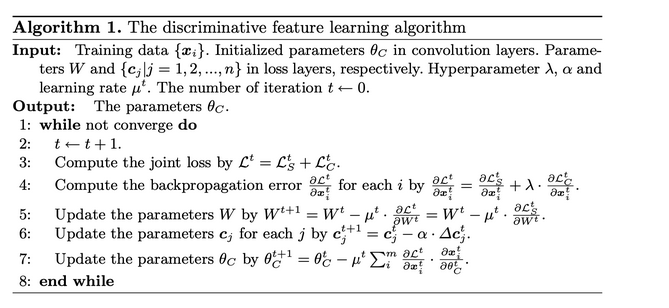

**Joint loss equation**

$L_{Joint} = L_{ID} + L_{Triplet} + \beta L_{Center}$

where
- $L_{Joint}$ = joint loss
- $L_{ID}$ = identity loss (cross entropy loss in this implementation)
- $L_{Triplet}$ = triplet loss
- $L_{Center}$ = center loss
- $\beta$ = center loss weights (affects only the triplet network, not center update)

The training procedure of the triplet network consists of the following steps:

1. Forward pass the `anchor_img`
2. Forward pass the `positive_img`  
3. Forward pass the `negative_img`
4. Calculate the distance between the feature vectors of `anchor_img`, `positive_img` and `negative_img` and calculate a triplet loss ($L_{Triplet}$).
5. Calculate the classification loss ($L_{ID}$).
6. Calculate the center loss ($L_{Center}$).
7. Scale the center loss with the predetermined weight ($\beta$) (only used to update the triplet network not to update the centroids).
8. Sum the losses from steps 4-7 and update the triplet network. (Line 3-5)
9. Rescale the gradients with $\frac{1}{\beta}$ at the loss in step 7 and update the centroids. (Line 6-7)
10. Repeat steps 1-9 till converge

As you would notice, steps 1- 3 share the same model weight for feature extraction. Thus, the word "triplet" in triplet loss originates in a similar fashion as the "Siamese twins" but this loss function utilizes three feature vectors simultaneously instead of two.


**Hint**

1. At the gradient rescaling for the centroids, we should iterate parameters in center loss first with `.parameters()` and adjust the property of each parameter with `.grad.data`



In [ ]:
num_epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"

os.makedirs('weights', exist_ok=True)
best_weights_path = 'weights/best_triplet_weights.pth'
triplet_model.to(device)
min_val_loss = float('inf')

train_losses = []
train_triplet_losses = []
train_crossentropy_losses = []
train_center_losses = []

val_losses = []
val_triplet_losses = []

for epoch in tqdm(range(num_epochs)):
    triplet_model.train()
    total_train_loss = 0
    total_train_triplet_loss = 0
    total_train_crossentropy_loss = 0
    total_train_center_loss = 0
    for anchor_img, pos_img, neg_img, anchor_label, pos_label, neg_label in tqdm(train_triplet_dataloader):

        # feed data to the triplet model and compute triplet loss
        anchor_img, pos_img, neg_img = anchor_img.to(device), pos_img.to(device), neg_img.to(device)
        anchor_label, pos_label, neg_label = anchor_label.to(device), pos_label.to(device), neg_label.to(device)
        labels = torch.cat((anchor_label, pos_label, neg_label))

        anchor_feat, pos_feat, neg_feat, feats, scores = triplet_model(anchor_img, pos_img, neg_img)
        train_triplet_loss = triplet_criterion(anchor_feat, pos_feat, neg_feat)

        # compute cross entropy loss
        train_crossentropy_loss = crossentropy_criterion(scores, labels)


        # compute center loss
        train_center_loss = triplet_center_loss_weight * triplet_center_criterion(feats, labels)


        train_loss = train_triplet_loss + train_crossentropy_loss + train_center_loss
        total_train_loss += train_loss.item()
        total_train_triplet_loss += train_triplet_loss.item()
        total_train_crossentropy_loss += train_crossentropy_loss.item()
        total_train_center_loss += train_center_loss.item()

        # set zero gradients at two optimizers
        triplet_optimizer.zero_grad()
        triplet_center_optimizer.zero_grad()

        # back propagate at triplet network and step the main optimizer
        train_loss.backward()
        triplet_optimizer.step()

        # rescale gradients of centers because `triplet_center_loss_weight` should not affect to learning the centers
        # and step the center optimizer
        for param in triplet_center_criterion.parameters():
          param.grad.data *= (1. / triplet_center_loss_weight)
        triplet_center_optimizer.step()

    current_train_loss = total_train_loss / len(train_triplet_dataloader)
    current_train_triplet_loss = total_train_triplet_loss / len(train_triplet_dataloader)
    current_train_crossentropy_loss = total_train_crossentropy_loss / len(train_triplet_dataloader)
    current_train_center_loss = total_train_center_loss / len(train_triplet_dataloader)
    train_losses.append(current_train_loss)
    train_triplet_losses.append(current_train_triplet_loss)
    train_crossentropy_losses.append(current_train_crossentropy_loss)
    train_center_losses.append(current_train_center_loss)

    total_val_loss = 0
    total_val_triplet_loss = 0
    triplet_model.eval()
    for val_anchor_img, val_pos_img, val_neg_img, _, _, _ in val_triplet_dataloader:

      # feed data to the triplet model and compute triplet loss
      val_anchor_img, val_pos_img, val_neg_img = val_anchor_img.to(device), val_pos_img.to(device), val_neg_img.to(device)
      with torch.no_grad():
          val_anchor_feat = triplet_model.extract_feature(val_anchor_img)
          val_pos_feat = triplet_model.extract_feature(val_pos_img)
          val_neg_feat = triplet_model.extract_feature(val_neg_img)
          val_triplet_loss = triplet_criterion(val_anchor_feat, val_pos_feat, val_neg_feat)

      val_loss = val_triplet_loss
      total_val_loss += val_loss.item()
      total_val_triplet_loss += val_triplet_loss.item()
    current_val_loss = total_val_loss / len(val_triplet_dataloader)
    current_val_triplet_loss = total_val_triplet_loss / len(val_triplet_dataloader)
    val_losses.append(current_val_loss)
    val_triplet_losses.append(current_val_triplet_loss)

    if current_val_loss < min_val_loss:
        min_val_loss = current_val_loss
        torch.save(triplet_model.state_dict(), best_weights_path)
    print(f'Epoch {epoch+1} - Train loss = {current_train_loss:.4f} - Train triplet loss = {current_train_triplet_loss:.4f} - Train crossentropy loss = {current_train_crossentropy_loss:.4f}  - Train center loss = {current_train_center_loss:.4f} - Val loss = {current_val_loss:.4f} - Val triplet loss = {current_val_triplet_loss:.4f} - best min_val_loss = {min_val_loss:.4f} - lr = {triplet_optimizer.param_groups[0]["lr"]:.8f}')
    triplet_scheduler.step(current_val_loss)

## 2.7 Visualization

The visualization below displays an anchor, positive, and negative image and their respective distance.

In [ ]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(20, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

best_weights_path = 'weights/best_triplet_weights.pth'
triplet_model.to(device)
triplet_model.load_state_dict(torch.load(best_weights_path))
triplet_model.eval()

test_anchor_imgs, test_pos_imgs, test_neg_imgs, test_anchor_ids, _, _ = next(iter(test_triplet_dataloader))
test_anchor_imgs, test_pos_imgs, test_neg_imgs = test_anchor_imgs.to(device), test_pos_imgs.to(device), test_neg_imgs.to(device)
with torch.no_grad():
    test_anchor_feats = triplet_model.extract_feature(test_anchor_imgs)
    test_pos_feats = triplet_model.extract_feature(test_pos_imgs)
    test_neg_feats = triplet_model.extract_feature(test_neg_imgs)

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnormalizer = UnNormalize(mean=[0.5319, 0.4399, 0.3929],
                          std=[0.3076, 0.2898, 0.2907])

zip_test_data = zip(test_anchor_feats, test_pos_feats, test_neg_feats, test_anchor_imgs, test_pos_imgs, test_neg_imgs)
for test_anchor_feat, test_pos_feat, test_neg_feat, test_anchor_img, test_pos_img, test_neg_img in zip_test_data:
    test_anchor_img = unnormalizer(test_anchor_img.detach().cpu().unsqueeze(0))
    test_pos_img = unnormalizer(test_pos_img.detach().cpu().unsqueeze(0))
    test_neg_img = unnormalizer(test_neg_img.detach().cpu().unsqueeze(0))
    concatenated = torch.cat((test_anchor_img, test_pos_img, test_neg_img), 0)
    anc_pos_distance = F.pairwise_distance(test_anchor_feat.unsqueeze(0), test_pos_feat.unsqueeze(0))
    anc_neg_distance = F.pairwise_distance(test_anchor_feat.unsqueeze(0), test_neg_feat.unsqueeze(0))
    imshow(torchvision.utils.make_grid(concatenated), f'Anc-Pos Distance: {anc_pos_distance.item():.4f}, Anc-Neg Distance: {anc_neg_distance.item():.4f}')

## 2.8 Plot loss history

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1, len(train_losses)+1), train_losses, label='train loss')
plt.plot(np.arange(1, len(val_losses)+1), val_losses, label='val loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1, len(train_losses)+1), train_triplet_losses, label='train triplet loss')
plt.plot(np.arange(1, len(val_losses)+1), val_triplet_losses, label='val triplet loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1, len(train_losses)+1), train_center_losses, label='train center loss')
plt.legend()
plt.show()

## 2.9 (TODO) Plot t-SNE

This section is similar to section 1.8 but the network is instead optimized using a combined triplet, center, and cross-entropy loss.

**Instructions**

TODO 12: Extract the feature vectors of the test set and store them as

`embeddings`: torch.FloatTensor = feature vectors of all images in the test set

`identities`: list or torch.Tensor or np.array = identities of all images in the test set

**Hint**      
Use `FaceDataset` that is imported at `Common Dataset` section

**WARNING!!**
Don't forget load its best weights and change to eval mode first

In [30]:
test_batch_size = 32

# TODO 12: Extract the feature vectors of the test set and store them as
# `embeddings`: torch.FloatTensor = feature vectors of all images in the test set
# `identities`: list or torch.Tensor or np.array = identities of all images in the test set
# Hint      => Use `FaceDataset` that is imported at `Common Dataset` section
# WARNING!! => Don't forget load its best weights and change to eval mode first
device = 'cpu'
num_classes = 80
best_weights_path = 'weights/best_triplet_weights.pth'
test_dataset = FaceDataset(root_dir="large_prepared_data/test", transform=val_transform)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

embeddings = torch.FloatTensor().to(device)
identities = []

triplet_model = TripletNetwork(num_classes)
triplet_model.load_state_dict(torch.load(best_weights_path, map_location=torch.device(device)))
triplet_model = triplet_model.to(device)
triplet_model.eval()

for transformed_img, identity, img in tqdm(test_dataloader):
    identities.extend(identity)
    with torch.no_grad():
        embeddings = torch.cat(
            (
                embeddings,
                triplet_model.extract_feature(transformed_img.to(device)).to(device),
            ),
            0,
        )

/Users/wagyu/mambaforge/envs/pattern/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/Users/wagyu/mambaforge/envs/pattern/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.



  0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
import time
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=3000)
tsne_result = tsne.fit_transform(embeddings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 301 samples in 0.000s...
[t-SNE] Computed neighbors for 301 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 301 / 301
[t-SNE] Mean sigma: 9.789319


[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.237343
[t-SNE] KL divergence after 1200 iterations: 0.810531
t-SNE done! Time elapsed: 1.6762092113494873 seconds


In [38]:
import plotly.express as px

label = []
idx = 0
id2label = dict()
for identity in identities:
  identity = int(identity)
  if identity not in id2label:
    id2label[identity] = idx
    idx += 1
  label.append(id2label[identity])

df_subset = pd.DataFrame({'label': label})

df_subset['tsne-2d-one'] = tsne_result[:,0]
df_subset['tsne-2d-two'] = tsne_result[:,1]

fig = px.scatter(df_subset, x="tsne-2d-one", y="tsne-2d-two", color="label", height=1000, width=1000)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

: 

In [33]:
import time
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=3000)
tsne_result = tsne.fit_transform(embeddings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 301 samples in 0.001s...
[t-SNE] Computed neighbors for 301 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 301 / 301
[t-SNE] Mean sigma: 9.789319


[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.458321
[t-SNE] KL divergence after 3000 iterations: 0.748369
t-SNE done! Time elapsed: 7.181657791137695 seconds


In [37]:
import plotly.express as px

label = []
idx = 0
id2label = dict()
for identity in identities:
  identity = int(identity)
  if identity not in id2label:
    id2label[identity] = idx
    idx += 1
  label.append(id2label[identity])

df_subset = pd.DataFrame({'label': label})

df_subset['tsne-3d-one'] = tsne_result[:,0]
df_subset['tsne-3d-two'] = tsne_result[:,1]
df_subset['tsne-3d-three'] = tsne_result[:,2]

fig = px.scatter_3d(df_subset, x="tsne-3d-one", y="tsne-3d-two", z="tsne-3d-three", color="label")
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## 2.10 (TODO) Embedding comparison

TODO 13: Compare the visualization of the triplet network to the siamese network. Which one is better and why?

Answer here: The embedding from triplet network clustered more better than siamese network. Because triplet network trained with more 
effective loss function including triplet loss that minimize the distance between the anchor and positive images and maximize the 
distance between the anchor and negative images. center loss that make the feature vectors of the same identity close to each other.
Contrast to siamese network that only minimize the distance between the anchor and positive images or maximize the distance between the anchor and negative images only.

## (Optional) Try other tricks to get higher quality of face embeddings such as
1. GeM Pooling (ref: https://amaarora.github.io/2020/08/30/gempool.html)
2. Arcface (ref: https://arxiv.org/abs/1801.07698)
3. Hard negative mining (ref: https://omoindrot.github.io/triplet-loss)
4. Semi-hard mining

and plot t-SNE to compare with vanilla triplet loss

# Part 3 : Face recognition using InfoNCE loss




In contrast to the contrastive and triplet loss that only pulls an image pair of the same identity to come closer and push a different one away, some alternative approaches, such as the N-pair (ref: [paper](https://papers.nips.cc/paper_files/paper/2016/file/6b180037abbebea991d8b1232f8a8ca9-Paper.pdf)) and InfoNCE (ref: [paper](https://arxiv.org/pdf/1807.03748v2.pdf)) loss, take multiple positive images or/and multiple negative images into consideration. In this part, you are going to implement a variant of the InfoNCE loss where multiple positive and negative images are simutaneously utilized during the learning process. Moreover, the loss function implemented in this homework also adopts temperature scaling, a concept widely applied in many state-of-the-art self-supervised learning such as SimCLR (ref: [paper](https://arxiv.org/abs/2002.05709)), instead of the margin used in triplet and vanilla contrastive loss.



## 3.1 (TODO) Dataset and DataLoader

In this section, you are going to implement a dataloader for the combined loss.
The dataloader should return the tuple `(anchor_img, pos_imgs, neg_imgs, anchor_label, pos_labels, neg_labels)`.

- The positive image must have the same identity as the anchor image.
- The negative image must have a different identity from the anchor image.

this dataloader will sample both multiple positive images and multiple negative images per anchor image

In [125]:
import copy

class InfoNCEDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_pos=4, num_neg=8):
        np.random.seed(123)
        random.seed(123)
        self.root_dir = root_dir
        self.transform = transform
        self.num_pos = num_pos
        self.num_neg = num_neg

        label_df = pd.read_csv(f'{root_dir}/label_df.csv')
        label_df = label_df.groupby('identity')['filename'].apply(list).reset_index().rename({'filename': 'filenames'}, axis=1)
        self.images = []
        self.labels = []
        self.label2indices = dict()
        self.load_images_to_memory_(label_df)

    def load_images_to_memory_(self, label_df):
        # load images and labels into memory
        # We have to relabel from identities to 0,1,2,...,num_classes-1
        # Relevant variables
        # 1. `self.images` = PIL images  (Also convert it to RGB)
        # 2. `self.label2indices` = the dictionary storing a label as a key and the indices of images as value
        # 3. `self.labels` = labels of images (relabeled)
        # Note: the index of images is from iterating over label_df
        self.images = []
        self.label2indices = defaultdict(list)
        self.labels = []
        img_idx = 0
        label_idx = 0
        identity2label = dict()
        for idx in tqdm(range(len(label_df))):
            row = label_df.iloc[idx]
            identity, filenames = row['identity'], row['filenames']

            if identity not in identity2label:
                identity2label[identity] = label_idx
                label_idx += 1

            label = identity2label[identity]

            for filename in filenames:
                self.images.append(Image.open(f'{self.root_dir}/{filename}').convert('RGB'))
                self.labels.append(label)
                self.label2indices[label].append(img_idx)
                img_idx += 1

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        '''
      sample images labels
      [args]
      - idx is an index of an image

      [intermediate]
      - anchor image is the image according to idx
      - positive images (dim: [num_pos, num_feat]) is a list of image that has the same identity with the anchor image (no duplicated images in this list)
      - negative images (dim: [num_neg, num_feat]) is a list of image that has the different identity with the anchor image (no duplicated images in this list)

      [return]
      - transformed_anchor_img is the transformed anchor image
      - transformed_pos_imgs are the tensor of transformed positive images
      - transformed_neg_img are the tensor of transformed negative images
      - anchor_label is the label of the anchor image
      - pos_labels are the list of positive labels
      - neg_labels are the list of negative labels
      '''

        anchor_img = self.images[idx]
        anchor_label = self.labels[idx]

        # TODO 14: sample positive images corresponding with the identity of anchor image
        ## condition:
        ## - there is no duplicated positive images
        ### Hint: Please use self.num_pos to determine the number of sampled positive images
        pos_labels = [anchor_label] * self.num_pos
        pos_idxs = random.choices(self.label2indices[anchor_label], k=self.num_pos)

        # TODO 15: sample negative images that their identities differs from the identity of anchor image
        ## condition:
        ## - the list of negative images can contain identical identities
        ## - there is no duplicated negative images
        ### Hint: Please use self.num_neg to determine the number of sampled negative images
        neg_labels = random.choices(list(set(self.label2indices.keys()) - {anchor_label}), k=self.num_neg)
        neg_idxs = [random.choice(self.label2indices[neg_label]) for neg_label in neg_labels]

        """
        neg_imgs = []
        for _ in range(self.num_neg):
            neg_label = random.choice(list(set(self.labels) - {anchor_label}))
            neg_img = random.choice(self.label2indices[neg_label])
            neg_labels.append(neg_label)
            neg_imgs.append(neg_img)
        """

        # TODO 16: utilize `self.transform' to convert anchor image, positive images, and negative images to tensors
        # WARNING!: Don't forget to convert to be tensors
        anchor_img = self.transform(anchor_img)
        pos_imgs = torch.stack([self.transform(self.images[pos_idx]) for pos_idx in pos_idxs])
        neg_imgs = torch.stack([self.transform(self.images[neg_idx]) for neg_idx in neg_idxs])

        return anchor_img, pos_imgs, neg_imgs, anchor_label, pos_labels, neg_labels

In [130]:
image_size = 224
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5319, 0.4399, 0.3929],
                          std=[0.3076, 0.2898, 0.2907])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5319, 0.4399, 0.3929],
                          std=[0.3076, 0.2898, 0.2907])
])

train_batch_size = 16
val_batch_size = 16
test_batch_size = 16

# TODO 17: declare the datasets and the dataloaders
train_infonce_dataset = InfoNCEDataset(root_dir='large_prepared_data/train', transform=train_transform)
train_infonce_dataloader = DataLoader(train_infonce_dataset, batch_size=train_batch_size, shuffle=True)

val_infonce_dataset = InfoNCEDataset(root_dir='large_prepared_data/val', transform=val_transform)
val_infonce_dataloader = DataLoader(val_infonce_dataset, batch_size=val_batch_size)

test_infonce_dataset = InfoNCEDataset(root_dir='large_prepared_data/test', transform=val_transform)
test_infonce_dataloader = DataLoader(test_infonce_dataset, batch_size=test_batch_size)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [131]:
anchor_img, pos_imgs, neg_imgs, anchor_label, pos_labels, neg_labels = train_infonce_dataset[0]

In [132]:
anchor_img.shape, pos_imgs.shape, neg_imgs.shape, anchor_label, pos_labels, neg_labels

(torch.Size([3, 224, 224]),
 torch.Size([4, 3, 224, 224]),
 torch.Size([8, 3, 224, 224]),
 0,
 [0, 0, 0, 0],
 [72, 4, 43, 27, 68, 13, 27, 27])

In [133]:
# get data from the dataloader
anchor_img, pos_imgs, neg_imgs, anchor_label, pos_labels, neg_labels = next(iter(train_infonce_dataloader))

In [136]:
anchor_img.shape, pos_imgs.shape, neg_imgs.shape, anchor_label.shape, pos_labels, neg_labels

(torch.Size([16, 3, 224, 224]),
 torch.Size([16, 4, 3, 224, 224]),
 torch.Size([16, 8, 3, 224, 224]),
 torch.Size([16]),
 [tensor([63,  6,  8, 64,  6, 54, 16, 42, 24, 55, 19, 27,  5, 35,  2, 44]),
  tensor([63,  6,  8, 64,  6, 54, 16, 42, 24, 55, 19, 27,  5, 35,  2, 44]),
  tensor([63,  6,  8, 64,  6, 54, 16, 42, 24, 55, 19, 27,  5, 35,  2, 44]),
  tensor([63,  6,  8, 64,  6, 54, 16, 42, 24, 55, 19, 27,  5, 35,  2, 44])],
 [tensor([52, 61, 27, 77,  9, 50, 31, 62, 76, 31, 76, 73, 55,  2,  1, 41]),
  tensor([ 9, 41, 31, 49,  4, 12,  9, 12, 40,  2, 68,  9, 40, 40, 54, 73]),
  tensor([72, 55,  5, 18, 29, 77, 78, 25, 60, 57, 25, 20, 72, 72, 16, 51]),
  tensor([23, 51, 37, 38,  8,  5, 41, 40, 71, 66, 17, 65, 22, 48, 22, 30]),
  tensor([34, 53, 46, 14, 35, 69, 50, 44,  1, 69, 36, 25, 76, 75, 14, 64]),
  tensor([37, 71, 27, 79,  0, 11, 64, 27, 21, 26, 65, 75, 15, 56, 59, 35]),
  tensor([37, 39, 15, 35, 43, 52, 31,  8, 18, 73, 15,  4,  1, 72, 42,  4]),
  tensor([ 2, 53,  6, 59,  5, 59,  4, 58, 

## 3.2 (TODO) Image encoder

Image encoder consists of 3 modules
1. Feature extractor (ResNet18) is for mapping an image to a feature map   
2. Global pooling (Global average pooling or use flatten instead) is for converting a feature map to a feature vector
3. Projection layer consists of 2 MLP layers to reduce dimension of feature vector together with a relu activation function at the middle of MLP layers

**Note**
1. ResNet18 can call via `torchvision` library (How to use torchvision: https://pytorch.org/vision/stable/models.html)
2. ResNet18 we use will not load pretrained weights
3. We will use ResNet18 only extracting feature maps.

**Hint!**
1. For global average pooling, read the documentation of `nn.AdaptiveAvgPool2d`


Figure 8 Image Encoder

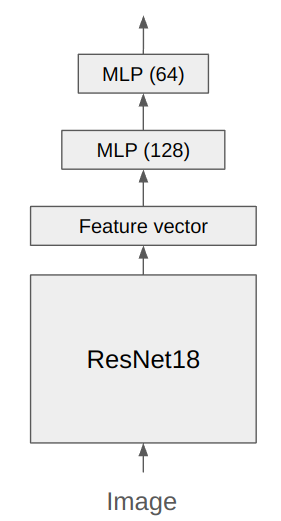

In [113]:
class ImageEncoder(nn.Module):
    # TODO 18: implement the image encoder according to the above figure
    def __init__(self):
        super(ImageEncoder, self).__init__()
        self.resnet = torchvision.models.resnet18()
        # self.global_pool = nn.AdaptiveAvgPool2d(1000)
        self.ff1 = nn.Linear(1000, 128)
        self.ff2 = nn.Linear(128, 64)

    def extract_feature(self, x):
        feature_vector = self.resnet(x)
        # output = self.global_pool(output)
        hd1 = F.relu(self.ff1(feature_vector))
        output = F.relu(self.ff2(hd1))
        return output

    def forward(self, input1, input2, input3):
        output1 = self.extract_feature(input1)
        output2 = self.extract_feature(input2)
        output3 = self.extract_feature(input3)
        return output1, output2, output3

In [114]:
out1, out2, out3 = ImageEncoder()(anchor_img.unsqueeze(0), pos_imgs, neg_imgs)

In [115]:
out1.shape, out2.shape, out3.shape

(torch.Size([1, 64]), torch.Size([4, 64]), torch.Size([8, 64]))

## 3.3 (TODO) InfoNCE loss
Information Noise Contrastive Estimation (InfoNCE) loss (ref: [blog](https://lilianweng.github.io/posts/2021-05-31-contrastive/), [paper](https://arxiv.org/pdf/1807.03748v2.pdf)) is a self-supervised training objective aiming to maximizes the agreement between positive samples and minimizes the agreement between negative samples in the learned representation space. Although primarily designed for self-supervised learning, it could also be used in supervised setting by utilizing information from the labeled data.

When under self-supervision, images are sampled in batches, each of which is then augmented using two different augmentation policies. The contrastive loss is subsequently computed to maximize the similarity of the images of the same origin before augmentation while minimizing the similarity of the ones with different origins. In supervised learning, the objective maximizes the similarity of the images with the same identity (class) instead of origin. <b>In this part, we will train the InfoNCE loss under the supervised setting.</b>

To put it simply, the InfoNCE loss revolves around three types of images:

1. Anchor image: an initial image
2. Positive images: the sampled images with the same identity as the anchor image
3. Negative images: the sampled images whose identity differs from that of the anchor image

The objective is to maximize the cosine similarity between groups 1 and 2 while pushing groups 1 and 3 away. Thus, the InfoNCE maximizes the following objective:


\begin{align}
InfoNCE\ Loss_i = \frac{1}{B \cdot P} \sum_{i=1}^B \sum_{p \in {P(i)}} \frac{e^{(cos(f_i, f_p) / \tau)}}{(e^{cos(f_i, f_p) / \tau)} + \sum_{n \in N(i)} e^{(cos(f_i, f_n) / \tau)}}
\end{align}

Notation
- $B$ = batch size
- $P$ = the number of positive images per anchor
- $i$ = index of the anchor feature vector
- $P(i)$ = the sampled positive feature vectors   
- $N(i)$ = the sampled negative feature vectors
- $cos(f_i, f_p)$ = cosine similarity between $f_i$ and $f_p$
- $f_i$ = anchor feature vector
- $f_p$ = positive feature vector
- $f_n$ = negative feature vector
- $\tau$ = temperature (a scaling factor for increasing/reducing the magnitude of logits)

**Hint** use `nn.CrossEntropy` to compute the exponential part  

In [264]:
class InfoNCELoss(nn.Module):
    # TODO 19: implement the InfoNCE loss
    def __init__(self, device, temperature):
        super(InfoNCELoss, self).__init__()
        self.device = device
        self.temperature = temperature

    def forward(
        self, anchor_feat, pos_feats, neg_feats
    ):  # (B, 1, D), (B, P, D), (B, N, D)
        # print(anchor_feat.shape, pos_feats.shape, neg_feats.shape)
        losses = []
        for b in range(pos_feats.size(0)):
            # print(anchor_feat[0].shape, pos_feats[b].shape, neg_feats[b].shape)
            # print(F.cosine_similarity(anchor_feat[0], pos_feats[b], dim=1))
            # print((F.cosine_similarity(anchor_feat[0], neg_feats[b], dim=1)/self.temperature).exp().sum())
            ce = F.cross_entropy(
                torch.cat(
                    (
                        F.cosine_similarity(anchor_feat[0], pos_feats[b], dim=1)/self.temperature,
                        F.cosine_similarity(anchor_feat[0], neg_feats[b], dim=1)/self.temperature,
                    )
                ),
                torch.cat(
                    (torch.ones(pos_feats.size(1)), torch.zeros(neg_feats.size(1)))
                ),
                reduction="sum",
            )
            
            # print(ce)
            
            losses.append(ce)

        return (torch.mean(torch.stack(losses)) / pos_feats.size(1)).to(self.device)

In [265]:
InfoNCELoss('cpu', 0.2)(out1.unsqueeze(0), out2.unsqueeze(0), out3.unsqueeze(0))

tensor(2.5148, grad_fn=<DivBackward0>)

In [266]:
InfoNCELoss("cpu", 0.2)(torch.randn(3, 1, 64), torch.randn(3, 4, 64), torch.randn(3, 8, 64))

tensor(2.5582)

## 3.4 (TODO) Initializing model, criterions, optimizers, hyparameters and scheduler

In [267]:
temperature = 0.2

infonce_model = ImageEncoder()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_infonce_criterion = InfoNCELoss(device, temperature)
val_infonce_criterion = InfoNCELoss(device, temperature)

infonce_optimizer = optim.Adam(infonce_model.parameters(), lr=5e-4)
infonce_scheduler = optim.lr_scheduler.ReduceLROnPlateau(infonce_optimizer, 'min', patience=4, factor=0.1, min_lr=1e-8)

## 3.5 (TODO) Training loop

Figure 9  How to connect the InfoNCE loss

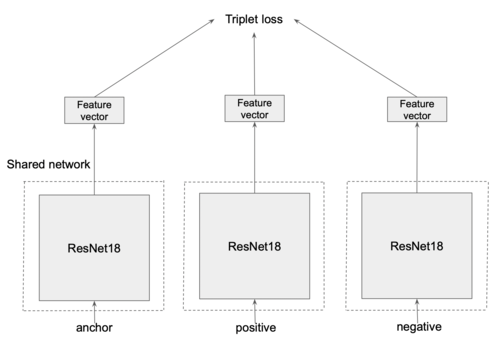


Fig 9 demonstrates how to connect multiple feature vectors to compute InfoNCE loss. The feature extractor shares all parameters between input images.  


The training procedure of a infonce network consists of the following steps:

1. Foward pass `anchor_img`
2. Foward pass `pos_imgs`
3. Foward pass `neg_img`
4. Calculate all pairs cosine similarities between `anchor_img` and `pos_imgs`.
5. Calculate all pairs cosine similarities between `anchor_img` and `neg_imgs`.
6. Compute InfoNCE loss and take an average over them
7. Use the loss in step 6 to update the model
8. Repeat step 1-8 till converged

TODO 20: move training data to GPU memory, extract anchor, positive, negative features from images, and then use them to compute InfoNCE loss

TODO 21: set zero gradients

TODO 22 : back propagate at infonce network and step the optimizer

TODO 23: move validation data to GPU memory, extract anchor, positive, negative features from images, and then use them to compute InfoNCE loss


In [ ]:
num_epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"

os.makedirs('weights', exist_ok=True)
best_weights_path = 'weights/best_infonce_weights.pth'
infonce_model.to(device)
min_val_loss = float('inf')

train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    infonce_model.train()
    total_train_loss = 0
    for anchor_img, pos_imgs, neg_imgs, anchor_label, pos_labels, neg_labels in tqdm(train_infonce_dataloader):
        print(anchor_img.shape, pos_imgs.shape, neg_imgs.shape)

        # TODO 20: feed data to the infonce model and compute infonce loss
        outputs1, outputs2, outputs3 = [], [], []
        for b in range(train_infonce_dataloader.batch_size):
            output1, output2, output3 = infonce_model(anchor_img[b].unsqueeze(0).to(device), pos_imgs[b].to(device), neg_imgs[b].to(device))
            print(output1.shape, output2.shape, output3.shape)
            outputs1.append(output1)
            outputs2.append(output2)
            outputs3.append(output3)
        
        print(torch.stack(outputs1).shape, torch.stack(outputs2).shape, torch.stack(outputs3).shape)
        train_loss = train_infonce_criterion(torch.stack(outputs1), torch.stack(outputs2), torch.stack(outputs3))
        
        total_train_loss += train_loss.item()

        # TODO 21: set zero gradients
        infonce_optimizer.zero_grad()

        # TODO 22 : back propagate at infonce network and step the optimizer
        train_loss.backward()
        infonce_optimizer.step()

    current_train_loss = total_train_loss / len(train_infonce_dataloader)
    train_losses.append(current_train_loss)

    total_val_loss = 0
    infonce_model.eval()

    for val_anchor_img, val_pos_imgs, val_neg_imgs, _, _, _ in val_infonce_dataloader:
      # TODO 23: feed data to the infonce model and compute infonce loss
      outputs1, outputs2, outputs3 = [], [], []
      for b in range(val_infonce_dataloader.batch_size):
        output1, output2, output3 = infonce_model(val_anchor_img[b].unsqueeze(0).to(device), val_pos_imgs[b].to(device), val_neg_imgs[b].to(device))
        outputs1.append(output1)
        outputs2.append(output2)
        outputs3.append(output3)
        
      val_infonce_loss = val_infonce_criterion(torch.stack(outputs1), torch.stack(outputs2), torch.stack(outputs3))

      val_loss = val_infonce_loss
      total_val_loss += val_loss.item()
    current_val_loss = total_val_loss / len(val_infonce_dataloader)
    val_losses.append(current_val_loss)

    if current_val_loss < min_val_loss:
        min_val_loss = current_val_loss
        torch.save(infonce_model.state_dict(), best_weights_path)
    print(f'Epoch {epoch+1} '
      f'- Train loss = {current_train_loss:.4f} '
      f'- Val loss = {current_val_loss:.4f} '
      f'- best min_val_loss = {min_val_loss:.4f} '
      f'- lr = {infonce_optimizer.param_groups[0]["lr"]:.8f}'
    )
    infonce_scheduler.step(current_val_loss)

: 

## 3.6 Visualization

The visualization below displays an anchor, positive, and negative image and their respective similarity.

In [ ]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(20, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

best_weights_path = 'weights/best_infonce_weights.pth'
infonce_model.to(device)
infonce_model.load_state_dict(torch.load(best_weights_path))
infonce_model.eval()

test_anchor_imgs, batch_test_pos_imgs, batch_test_neg_imgs, test_anchor_ids, _, _ = next(iter(test_infonce_dataloader))

test_pos_imgs = batch_test_pos_imgs[:, 0, :, :]
test_neg_imgs = batch_test_neg_imgs[:, 0, :, :]

test_anchor_imgs, test_pos_imgs, test_neg_imgs = test_anchor_imgs.to(device), test_pos_imgs.to(device), test_neg_imgs.to(device)
with torch.no_grad():
    test_anchor_feats = infonce_model.extract_feature(test_anchor_imgs)
    test_pos_feats = infonce_model.extract_feature(test_pos_imgs)
    test_neg_feats = infonce_model.extract_feature(test_neg_imgs)

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnormalizer = UnNormalize(mean=[0.5319, 0.4399, 0.3929],
                          std=[0.3076, 0.2898, 0.2907])

zip_test_data = zip(test_anchor_feats, test_pos_feats, test_neg_feats, test_anchor_imgs, test_pos_imgs, test_neg_imgs)
for test_anchor_feat, test_pos_feat, test_neg_feat, test_anchor_img, test_pos_img, test_neg_img in zip_test_data:
    test_anchor_img = unnormalizer(test_anchor_img.detach().cpu().unsqueeze(0))
    test_pos_img = unnormalizer(test_pos_img.detach().cpu().unsqueeze(0))
    test_neg_img = unnormalizer(test_neg_img.detach().cpu().unsqueeze(0))
    concatenated = torch.cat((test_anchor_img, test_pos_img, test_neg_img), 0)
    anc_pos_similarity = F.cosine_similarity(test_anchor_feat.unsqueeze(0), test_pos_feat.unsqueeze(0))
    anc_neg_similarity = F.cosine_similarity(test_anchor_feat.unsqueeze(0), test_neg_feat.unsqueeze(0))
    imshow(torchvision.utils.make_grid(concatenated), f'Anc-Pos similarity: {anc_pos_similarity.item():.4f}, Anc-Neg similarity: {anc_neg_similarity.item():.4f}')

## 3.7 Plot loss history

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1, len(train_losses)+1), train_losses, label='train loss')
plt.plot(np.arange(1, len(val_losses)+1), val_losses, label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

## 3.8 (TODO) Plot t-SNE

This section is similar to section 1.8  

**Instructions**

TODO 24: Extract the feature vectors of the test set and store them as

`embeddings`: torch.FloatTensor = feature vectors of all images in the test set

`identities`: list or torch.Tensor or np.array = identities of all images in the test set

**Hint**      
Use `FaceDataset` that is imported at `Common Dataset` section

**WARNING!!**
Don't forget load its best weights and change to eval mode first

In [ ]:
test_batch_size = 32

# TODO 24: Extract the feature vectors of the test set and store them as
# `embeddings`: torch.FloatTensor = feature vectors of all images in the test set
# `identities`: list or torch.Tensor or np.array = identities of all images in the test set
# Hint      => Use `FaceDataset` that is imported at `Common Dataset` section
# WARNING!! => Don't forget load its best weights and change to eval mode first
embeddings = None
identities = None

In [ ]:
import time
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=3000)
tsne_result = tsne.fit_transform(embeddings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
import plotly.express as px

label = []
idx = 0
id2label = dict()
for identity in identities:
  identity = int(identity)
  if identity not in id2label:
    id2label[identity] = idx
    idx += 1
  label.append(id2label[identity])

df_subset = pd.DataFrame({'label': label})

df_subset['tsne-2d-one'] = tsne_result[:,0]
df_subset['tsne-2d-two'] = tsne_result[:,1]

fig = px.scatter(df_subset, x="tsne-2d-one", y="tsne-2d-two", color="label", height=1000, width=1000)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
import time
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=3000)
tsne_result = tsne.fit_transform(embeddings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
import plotly.express as px

label = []
idx = 0
id2label = dict()
for identity in identities:
  identity = int(identity)
  if identity not in id2label:
    id2label[identity] = idx
    idx += 1
  label.append(id2label[identity])

df_subset = pd.DataFrame({'label': label})

df_subset['tsne-3d-one'] = tsne_result[:,0]
df_subset['tsne-3d-two'] = tsne_result[:,1]
df_subset['tsne-3d-three'] = tsne_result[:,2]

fig = px.scatter_3d(df_subset, x="tsne-3d-one", y="tsne-3d-two", z="tsne-3d-three", color="label")
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## 3.9 (TODO) Please analyze and compare between the t-SNE of triplet network the t-SNE of InfoNCE network. Why are those t-SNEs not in the same way?  

TODO 25: Answer the above question  

**Hint** The reason is about our dataset

Answer:

# Part 4 : Face verification evaluation



In HW3, we use the ROC curve to measure the performance of the face verification task. Similarly, we will use this metric to measure the performance of our NN.

TODO 26: Use the Siamese network, network trained using triplet loss, and network trained using InfoNCE loss to extract the image features from the test set.


In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5319, 0.4399, 0.3929],
                          std=[0.3076, 0.2898, 0.2907])
])


test_siamese_dataset = SiameseDataset(root_dir='large_prepared_data/test', transform=val_transform)
test_siamese_dataloader = DataLoader(test_siamese_dataset, batch_size=test_batch_size, shuffle=False, num_workers=2)

siamese_embeddings1 = []
siamese_embeddings2 = []
triplet_embeddings1 = []
triplet_embeddings2 = []
infonce_embeddings1 = []
infonce_embeddings2 = []
labels = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'

siamese_model.to(device)
triplet_model.to(device)
infonce_model.to(device)

siamese_model.load_state_dict(torch.load('weights/best_siamese_weights.pth'))
triplet_model.load_state_dict(torch.load('weights/best_triplet_weights.pth'))
infonce_model.load_state_dict(torch.load('weights/best_infonce_weights.pth'))

siamese_model.eval()
triplet_model.eval()
infonce_model.eval()

for batch_img1, batch_img2, batch_label in tqdm(test_siamese_dataloader):
  batch_img1, batch_img2, batch_label = batch_img1.to(device), batch_img2.to(device), batch_label.to(device)
  with torch.no_grad():
    # TODO 26: extract features with both siamese network, triplet network, infonce network
    # and keep embeddings in provided lists according to variable names
    batch_img1, batch_img2 = batch_img1.to(device), batch_img2.to(device)
    siamese_embeddings1.append(siamese_model.extract_feature(batch_img1))
    siamese_embeddings2.append(siamese_model.extract_feature(batch_img2))
    triplet_embeddings1.append(triplet_model.extract_feature(batch_img1))
    triplet_embeddings2.append(triplet_model.extract_feature(batch_img2))
    infonce_embeddings1.append(infonce_model.extract_feature(batch_img1))
    infonce_embeddings2.append(infonce_model.extract_feature(batch_img2))

  labels.append(batch_label)

siamese_embeddings1 = torch.cat(siamese_embeddings1)
siamese_embeddings2 = torch.cat(siamese_embeddings2)
triplet_embeddings1 = torch.cat(triplet_embeddings1)
triplet_embeddings2 = torch.cat(triplet_embeddings2)
infonce_embeddings1 = torch.cat(infonce_embeddings1)
infonce_embeddings2 = torch.cat(infonce_embeddings2)
labels = torch.cat(labels)


TODO 27: Measure the similarity score between the two feature vectors with cosine similarity.

**HINT**
You can use `nn.CosineSimilarity`
(ref: https://pytorch.org/docs/stable/generated/torch.nn.CosineSimilarity.html).


In [ ]:
def compute_pairs_cosine_sim(input1, input2):
  # TODO 27: implement cosine similarity function that can compute multiple pairs at the same time
  return F.cosine_similarity(input1, input2, dim=1)

siamese_scores = compute_pairs_cosine_sim(siamese_embeddings1, siamese_embeddings2)
triplet_scores = compute_pairs_cosine_sim(triplet_embeddings1, triplet_embeddings2)
infonce_scores = compute_pairs_cosine_sim(infonce_embeddings1, infonce_embeddings2)

TODO 28

Plot a ROC curve to compare the performance siamese, triplet, infonce networks. Which one is better and why?

In [ ]:
import matplotlib.pyplot as plt
# TODO 28: calculate true positive rate and false positive rate
# and plot both the ROC curve of siamese network and the ROC curve of triplet network
# together with AUC score
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_score, model_name):
  fpr, tpr, _ = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
  plt.legend()
  
plot_roc_curve(labels.cpu().numpy(), siamese_scores.cpu().numpy(), 'Siamese')
plot_roc_curve(labels.cpu().numpy(), triplet_scores.cpu().numpy(), 'Triplet')
plot_roc_curve(labels.cpu().numpy(), infonce_scores.cpu().numpy(), 'InfoNCE')